In [2]:
%matplotlib inline

import pandas as pd
import scipy as sp
from scipy.optimize import fmin_slsqp
import numpy as np
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook

# 초기화

In [3]:
univ = pd.read_excel('simul_20191210.xlsx', sheet_name='category')[:-2]; univ;

In [4]:
regions = univ.region.unique(); regions

array(['US', 'Global', 'EM', 'DM'], dtype=object)

In [5]:
cats = univ.category.unique(); cats

array(['US_HD', 'US_HD_LV', 'US_DG', 'US_DG_QL', 'US_PS', 'Global', 'EM',
       'DM'], dtype=object)

In [6]:
prices = pd.read_excel('simul_20191210.xlsx', sheet_name='price', index_col=0)
rtns = np.log(prices).diff()

In [7]:
dvds = pd.read_excel('simul_20191210.xlsx', sheet_name='dvd', index_col=0)

# 초기전략: 최적화만 하는 경우

In [8]:
'''
변수설정
'''
n_dates = len(rtns)
n_cov = 12             # cov 계산 개월수

w_max = 0.10           # 종목 최대비중
w_us_min = 0.4         # 미국 최소비중
w_us_max = 0.8         # 미국 최대비중
w_ps_max = 0.1         # 우선주 최대비중
dvd_min = 2.5          # 포트폴리오 최소 배당수익률

n = len(rtns.columns)  # 종목수
w_p0 = np.zeros(n-3)   # 비중벡터 초기값

dates_rng = range(n_cov, n_dates)
weights = np.zeros((len(dates_rng), len(w_p0)))
result = {}


for i in tqdm_notebook(dates_rng):
    date = rtns.index[i]
    _rtns = rtns.iloc[i-11:i+1]
    dvd = dvds.iloc[i]
    
    investable = 1 - (dvd[:-2].isna() | _rtns.iloc[-1][1:-2].isna())
    bounds = list(zip(list(w_p0), list(w_p0 + w_max*investable)))
    
    # te 계산
    def te(w_p):
        w = np.zeros(n)
        w[1:-2] = w_p
        w[0] = 1
        cov = _rtns.cov(min_periods=n_cov/2).fillna(0)
        return w @ cov @ w

    # 비중합=0
    def sum_to_one(w_p):
        return 1 - w_p.sum()
    
    # 미국 최소비중
    def us_min(w_p):
        return w_p[:24].sum() - w_us_min

    # 미국 최대비중
    def us_max(w_p):
        return w_us_max - w_p[:24].sum()
    
    # 우선주 최대비중
    def ps_max(w_p):
        return w_ps_max - w_p[19:25].sum()

    # 포트폴리오 최소 배당수익률
    def dvd_sum_min(w_p):
        return dvd[:-2].fillna(0) @ w_p - dvd_min

    
    resp = fmin_slsqp(te, w_p0, 
                      eqcons=[sum_to_one], 
                      ieqcons=[us_min, us_max, ps_max, dvd_sum_min], 
                      bounds=bounds, iter=1000, full_output=True, iprint=0)
    
    if resp[3]==0:
        pos = resp[0]
        weights[i-n_cov,:] = pos
        
        result[date] = {
            'te': resp[1]**0.5, 
            'w_total': pos.sum(),
            'w_us': pos[:24].sum(),
            'dvd': dvd_sum_min(pos) + dvd_min, 
        }
        
    else:
        print(date, resp[-1])

In [9]:
df_result = pd.DataFrame(result).T; df_result

,te,w_total,w_us,dvd
2010-12-31,0.104448,1.0,0.800000,3.544815
2011-01-31,0.100125,1.0,0.800000,3.560929
2011-02-28,0.100347,1.0,0.800000,3.487667
2011-03-31,0.097373,1.0,0.800000,3.479074
2011-04-29,0.098990,1.0,0.800000,3.386458
...,...,...,...,...
2019-07-31,0.078101,1.0,0.642679,4.395097
2019-08-30,0.079143,1.0,0.641492,4.457073
2019-09-30,0.081572,1.0,0.657844,4.269938
2019-10-31,0.074587,1.0,0.520177,4.152526


In [10]:
df_w = pd.DataFrame(weights, index=df_result.index, columns=dvds.columns[:-2]).shift(1); df_w;

In [11]:
df_rtns = rtns.loc[df_result.index, dvds.columns[:-2]]; df_rtns;

In [12]:
cum_port0 = (df_w*df_rtns).sum(axis=1).cumsum()

In [13]:
cum_bm = rtns.loc[df_result.index]['M1ACWIHD INDEX']
cum_bm.iloc[0] = 0
cum_bm = cum_bm.cumsum()

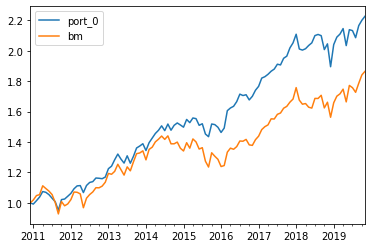

In [14]:
cum = np.exp(pd.DataFrame({'port_0':cum_port0, 'bm':cum_bm}))
cum.plot()

In [15]:
std = cum.pct_change().std()*(12**0.5)
cagr = cum.iloc[-1]**(12/(len(cum)-1))-1
rar = cagr/std
stats = pd.DataFrame({'cagr':cagr, 'std':std, 'rar':rar}); stats

,cagr,std,rar
port_0,0.093935,0.093304,1.006768
bm,0.072373,0.112851,0.641317


# 모멘텀 종목 고르는 경우

In [41]:
'''
변수설정
'''
n_dates = len(rtns)

n_filter = 0.5         # 모멘텀 상위 50%만 선택
n_cov = 12             # cov 계산 개월수

w_max = 0.10           # 종목 최대비중
w_us_min = 0.4         # 미국 최소비중
w_us_max = 0.8         # 미국 최대비중
w_ps_max = 0.1         # 우선주 최대비중
dvd_min = 2.5          # 포트폴리오 최소 배당수익률

n = len(rtns.columns)  # 종목수
w_p0 = np.zeros(n-3)   # 비중벡터 초기값

dates_rng = range(n_cov, n_dates)
weights = np.zeros((len(dates_rng), len(w_p0)))
result = {}


# 모멘텀 종목 걸러내기
def has_momentum(rt):
    univ['momentum'] = rt.iloc[-3:].sum(min_count=2)[1:-2].values
    return univ.groupby('category')['momentum'].rank(ascending=False, pct=True, na_option='bottom') <= n_filter


for i in tqdm_notebook(dates_rng):
    date = rtns.index[i]
    _rtns = rtns.iloc[i-11:i+1]
    dvd = dvds.iloc[i]
    
    investable = 1 - (dvd[:-2].isna() | _rtns.iloc[-1][1:-2].isna())
    investable = investable.values * has_momentum(_rtns)
    bounds = list(zip(list(w_p0), list(w_p0 + w_max*investable)))
    
    # te 계산
    def te(w_p):
        w = np.zeros(n)
        w[1:-2] = w_p
        w[0] = 1
        cov = _rtns.cov(min_periods=n_cov/2).fillna(0)
        return w @ cov @ w

    # 비중합=0
    def sum_to_one(w_p):
        return 1 - w_p.sum()
    
    # 미국 최소비중
    def us_min(w_p):
        return w_p[:24].sum() - w_us_min

    # 미국 최대비중
    def us_max(w_p):
        return w_us_max - w_p[:24].sum()
    
    # 우선주 최대비중
    def ps_max(w_p):
        return w_ps_max - w_p[19:25].sum()

    # 포트폴리오 최소 배당수익률
    def dvd_sum_min(w_p):
        return dvd[:-2].fillna(0) @ w_p - dvd_min


    resp = fmin_slsqp(te, w_p0, 
                      eqcons=[sum_to_one], 
                      ieqcons=[us_min, us_max, ps_max, dvd_sum_min], 
                      bounds=bounds, iter=1000, full_output=True, iprint=0)
    
    
    # 최적화 성공한다면:
    if resp[3]==0:
        pos = resp[0]
        weights[i-n_cov,:] = pos
        
        result[date] = {
            'te': resp[1]**0.5, 
            'w_total': pos.sum(),
            'w_us': pos[:24].sum(),
            'dvd': dvd_sum_min(pos) + dvd_min, 
        }
        
    # 최적화 실패한다면:
    else:
        print(date, resp[-1])
        pos = resp[0]
        weights[i-n_cov,:] = pos
        
        result[date] = {
            'te': resp[1]**0.5, 
            'w_total': pos.sum(),
            'w_us': pos[:24].sum(),
            'dvd': dvd_sum_min(pos) + dvd_min, 
        }

2011-05-31 00:00:00 Inequality constraints incompatible


KeyboardInterrupt: 

In [ ]:
df_result = pd.DataFrame(result).T; df_result

In [20]:
df_w = pd.DataFrame(weights, index=df_result.index, columns=dvds.columns[:-2]).shift(1)

In [21]:
df_rtns = rtns.loc[df_result.index, dvds.columns[:-2]]

In [22]:
cum_port1 = (df_w*df_rtns).sum(axis=1).cumsum()

In [23]:
cum_bm = rtns.loc[df_result.index]['M1ACWIHD INDEX']
cum_bm.iloc[0] = 0
cum_bm = cum_bm.cumsum()

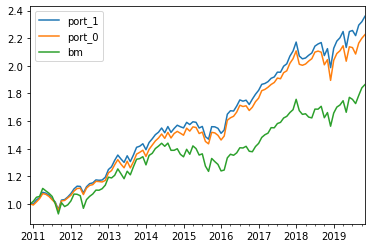

In [24]:
cum = np.exp(pd.DataFrame({'port_1':cum_port1, 'port_0':cum_port0, 'bm':cum_bm}))
cum.plot()

In [25]:
std = cum.pct_change().std()*(12**0.5)
cagr = cum.iloc[-1]**(12/(len(cum)-1))-1
rar = cagr/std
stats = pd.DataFrame({'cagr':cagr, 'std':std, 'rar':rar}); stats

,cagr,std,rar
port_1,0.101060,0.090741,1.113727
port_0,0.093935,0.093304,1.006768
bm,0.072373,0.112851,0.641317


# BM 모멘텀이 안나올때 UST 편입하는 경우

In [26]:
df_bm_rtns = rtns['M1ACWIHD INDEX'].rolling(3).sum().loc[df_result.index]

In [27]:
UST = 'TLT'

In [28]:
df_w_append = df_w.copy()
for date, val in df_bm_rtns.items():
    if val<0:
        df_w_append.loc[date] *= 0.8
        df_w_append.loc[date, UST] = 0.2

In [29]:
df_rtns[UST] = rtns.loc[df_result.index, UST]

In [30]:
cum_port2 = (df_w_append*df_rtns).sum(axis=1).cumsum()

In [31]:
cum_bm = rtns.loc[df_result.index]['M1ACWIHD INDEX']
cum_bm.iloc[0] = 0
cum_bm = cum_bm.cumsum()

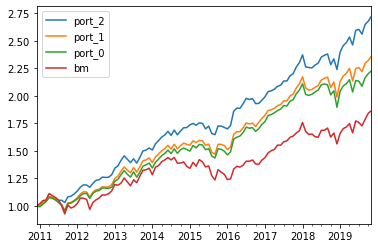

In [32]:
cum = np.exp(pd.DataFrame({'port_2':cum_port2, 'port_1':cum_port1, 'port_0':cum_port0, 'bm':cum_bm}))
cum.plot()

In [33]:
std = cum.pct_change().std()*(12**0.5)
cagr = cum.iloc[-1]**(12/(len(cum)-1))-1
rar = cagr/std
stats = pd.DataFrame({'cagr':cagr, 'std':std, 'rar':rar}); stats

,cagr,std,rar
port_2,0.118839,0.077017,1.543020
port_1,0.101060,0.090741,1.113727
port_0,0.093935,0.093304,1.006768
bm,0.072373,0.112851,0.641317


In [34]:
df_w.iloc[-1][df_w.iloc[-1]>0]

VYM     0.051250
FDL     0.080117
SCHD    0.039323
FVD     0.100000
DHS     0.055602
DIV     0.100000
NOBL    0.100000
DGRO    0.073709
FPE     0.066160
VRP     0.033840
VYMI    0.100000
DEM     0.100000
IDV     0.100000
Name: 2019-11-29 00:00:00, dtype: float64

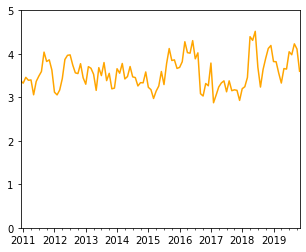

In [35]:
df_result.dvd.plot(color='orange', figsize=(5,4), ylim=(0,5))

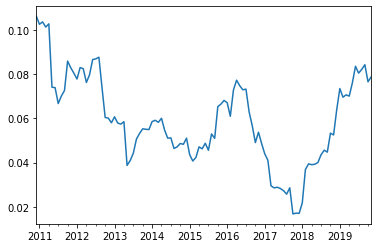

In [36]:
df_result.te.plot()

In [37]:
perf = np.exp(pd.DataFrame({'HGDM':cum_port2, 'MSCI AC High Div Index (BM)':cum_bm}))

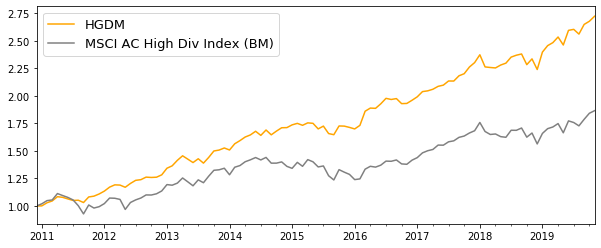

In [38]:
ax = perf.plot(figsize=(10,4), color=['orange','gray'])
ax.legend(fontsize=13)

In [39]:
ytd = perf.iloc[-1]/perf.loc['2018-12-31']-1
r3m = perf.iloc[-1]/perf.iloc[-4]-1
r1y = perf.iloc[-1]/perf.iloc[-13]-1
r3y = perf.iloc[-1]/perf.iloc[-37]-1

In [40]:
pd.DataFrame({'ytd':ytd, '1y':r1y, '3y':r3y})

,ytd,1y,3y
HGDM,0.216004,0.165736,0.409981
MSCI AC High Div Index (BM),0.193120,0.122125,0.353101
